# Análisis de distribución de casos + de Madrid

## Objetivo

El procedimiento de comunicación de datos positivos de Covid de la Comunidad de Madrid se basa en comunicar un número total diarios, primera página de este pdf por ejemplo, mencionándose, a continuación, los que corresponden al día anterior. El resto se distribuyen entre días pasados. Nos preguntamos como se hace ese reparto, hasta cuando se "reparten" esos positivos, ¿cuánto hacia atrás se están llevando?, qué equivale a decir: con qué retraso se están asignando esos casos, de hoy por ejemplo, a sus fechas reales?.
En este trabajo vamos a intentar responder a esa pregunta

## Pasos a seguir

1. Descargaremos los ficheros pdf del repositorio de la Comunidad de Madrid, desde el 01 de Septiembre. Este es, como ejemplo, el [fichero](https://www.comunidad.madrid/sites/default/files/doc/sanidad/200901_cam_covid19.pdf)  del 1 de Septiembre.
2. Leeremos esos ficheros buscando las tablas de acumulado, que aparecen en la página 2 y 3 de ese documento.
3. Construiremos, con esa información, la "visión" de casos que se ha tenido en cada uno de los días desde Septiembre, guardándolas como columnas de un `pandas`
4. A continuación calcularemos los incrementales diarios de cada día, es decir los positivos comunicados en el documento de un día en concreto: a qué días se están asignando.
5. En este punto tendremos un `pandas`con los datos de cada día de publicación en columna, y cada fila representa el día al que se asocia.
6. Por último desplazaremos cada columna para que cada fila represente de manera relativa días de diferencia con el de publicación (así hablaremos de que un dato presentado en día `t` se ha asignado a un día `t-3` por ejemplo, tres días anteriores.
7. Finalmente preparemos un gráfico para visualizar este comportamiento.

Para los pasos 1 y 2 he utilizado el script escrito por [@alfonsotwr](https://twitter.com/alfonsotwr) , disponible en su [github](https://github.com/alfonsotwr/snippets/tree/master/covidia-cam). Todo el código de esos pasos es suyo. 
Manos a la obra

## Código

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [1]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

Preparamos las expresiones regulares que nos ayudarán en la interpretación de la información que sacamos de los pdf.

In [2]:
df=pd.read_csv('csv/numeros_madrid24-12_2020.csv',index_col=0)

In [3]:
df.tail(60)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24
fecha_asignacion,,,,,,,,,,,,,,,,,,,,,
2020-10-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,325281.0,325984.0,326693.0,327304.0,327919.0,328234.0,328456.0,329144.0,329800.0,330528.0
2020-10-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,327328.0,328038.0,328754.0,329373.0,329997.0,330314.0,330538.0,331236.0,331901.0,332634.0
2020-10-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,329514.0,330230.0,330956.0,331585.0,332218.0,332538.0,332764.0,333476.0,334152.0,334894.0
2020-10-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,331481.0,332208.0,332939.0,333575.0,334216.0,334541.0,334769.0,335491.0,336177.0,336924.0
2020-10-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,333474.0,334209.0,334949.0,335590.0,336238.0,336564.0,336793.0,337524.0,338215.0,338973.0
2020-10-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,335628.0,336367.0,337117.0,337769.0,338423.0,338752.0,338982.0,339715.0,340420.0,341188.0
2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,336141.0,336884.0,337635.0,338290.0,338947.0,339276.0,339507.0,340241.0,340950.0,341724.0
2020-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,336587.0,337337.0,338091.0,338750.0,339410.0,339740.0,339973.0,340710.0,341424.0,342201.0
2020-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,337102.0,337856.0,338615.0,339276.0,339944.0,340278.0,340511.0,341252.0,341973.0,342760.0


In [ ]:
catorce_dias=dt.timedelta(days=14)

In [5]:
fecha_menos=(dt.datetime.strptime('2020-09-01','%Y-%m-%d')-catorce_dias).strftime('%Y-%m-%d')

In [6]:
df.loc['2020-09-01',df.columns=='2020-09-02']-df.loc[fecha_menos,df.columns=='2020-09-02']

2020-09-02    27315.0
dtype: float64

In [7]:
df_ratio = pd.DataFrame(index=df.columns[1:])
df_ratio['AI14']=0
df_ratio['AI14_7']=0

In [8]:
def calculo_AI(x):
    catorce_dias=dt.timedelta(days=14)
    un_dia=dt.timedelta(days=1)
    #print (x.name)
    fecha = dt.datetime.strptime(x.name,'%Y-%m-%d')
    ayer_dt = (fecha-un_dia)
    ayer = ayer_dt.strftime('%Y-%m-%d')
    inicio = (ayer_dt-catorce_dias).strftime('%Y-%m-%d')
    valor= df.loc[ayer,df.columns==x.name]-df.loc[inicio,df.columns==x.name]
    
    print (valor.values[0])
    return valor.values[0]

In [9]:
def calculo_AI_7(x):
    catorce_dias=dt.timedelta(days=14)
    un_dia=dt.timedelta(days=1)
    siete_dias=dt.timedelta(days=7)
    fecha = dt.datetime.strptime(x.name,'%Y-%m-%d')
    fecha_fin_dt = (fecha-siete_dias)
    fecha_fin = fecha_fin_dt.strftime('%Y-%m-%d')
    
    inicio = (fecha_fin_dt-catorce_dias).strftime('%Y-%m-%d')
    valor= df.loc[fecha_fin,df.columns==x.name]-df.loc[inicio,df.columns==x.name]
    
    print (valor.values[0])
    return valor.values[0]

In [10]:
df_ratio.loc[:,'AI14_7']=df_ratio.apply(calculo_AI_7,axis=1)

27925.0
28728.0
29389.0
31382.0
31871.0
32160.0
32630.0
32972.0
34583.0
35226.0
36369.0
37489.0
39020.0
41579.0
43431.0
45232.0
47016.0
48911.0
49965.0
50319.0
50494.0
50464.0
49391.0
47801.0
45995.0
44074.0
41674.0
38093.0
35018.0
33294.0
31900.0
30066.0
28113.0
26671.0
26073.0
26047.0
25150.0
24946.0
24304.0
23846.0
23319.0
22788.0
22791.0
22700.0
23961.0
23341.0
22619.0
22189.0
21716.0
21829.0
21871.0
20175.0
19633.0
19300.0
19011.0
18606.0
18738.0
18717.0
17643.0
17148.0
16849.0
16362.0
15768.0
15862.0
15733.0
16349.0
15675.0
14959.0
14287.0
13648.0
13567.0
13395.0
13353.0
12793.0
12244.0
11760.0
11431.0
11470.0
11377.0
11072.0
10746.0
10507.0
10463.0
10367.0
10489.0
10577.0
9957.0
9356.0
9677.0
10266.0
10984.0
11214.0
11418.0
11763.0
12290.0
12874.0
13434.0


In [11]:
df_ratio.loc[:,'AI14']=df_ratio.apply(calculo_AI,axis=1)

27315.0
27058.0
26718.0
29933.0
31326.0
30180.0
30624.0
30884.0
35133.0
37054.0
36523.0
37553.0
38838.0
42212.0
43812.0
42708.0
41997.0
40650.0
44447.0
44806.0
41896.0
39715.0
38064.0
34732.0
34926.0
32663.0
30987.0
29062.0
26255.0
24686.0
23882.0
23880.0
22957.0
22491.0
22377.0
21936.0
21438.0
20705.0
21984.0
21617.0
20974.0
20553.0
19923.0
19891.0
19843.0
18133.0
17740.0
17476.0
17241.0
16841.0
16957.0
16756.0
15787.0
15494.0
15357.0
15016.0
14430.0
14423.0
14268.0
14914.0
14272.0
13601.0
13029.0
12518.0
12425.0
12234.0
12265.0
11677.0
11146.0
10753.0
10365.0
10433.0
10338.0
10188.0
9880.0
9736.0
9751.0
9581.0
9635.0
9690.0
8966.0
8206.0
8403.0
8866.0
9459.0
9618.0
9806.0
10183.0
10684.0
11159.0
11760.0
12273.0
12642.0
12694.0
13985.0
15351.0
15913.0


In [12]:
df_ratio

,AI14,AI14_7
2020-09-02,27315.0,27925.0
2020-09-03,27058.0,28728.0
2020-09-04,26718.0,29389.0
2020-09-07,29933.0,31382.0
2020-09-08,31326.0,31871.0
...,...,...
2020-12-20,12642.0,11418.0
2020-12-21,12694.0,11763.0
2020-12-22,13985.0,12290.0
2020-12-23,15351.0,12874.0


In [13]:
df

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24
fecha_asignacion,,,,,,,,,,,,,,,,,,,,,
2020-02-25,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
2020-02-26,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
2020-02-27,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,11.0,...,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0
2020-02-28,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,22.0,...,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0
2020-02-29,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,29.0,...,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,387101.0,387498.0,389039.0,390379.0,391651.0
2020-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,387663.0,389273.0,390676.0,391969.0
2020-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,390242.0,391772.0,393271.0


In [14]:
ai14 = pd.DataFrame(index=df.index[:],columns=df.columns)



In [15]:
ai14

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24
fecha_asignacion,,,,,,,,,,,,,,,,,,,,,
2020-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
poblacion_madrid = 6642000

In [17]:
def test(x):
    return x.diff(periods=14)

In [18]:
ai14.loc[:,:]=df.apply(test)

In [19]:
ai14.index = pd.to_datetime(ai14.index)
ai14=ai14/poblacion_madrid*100000

In [20]:
ai14.iloc[-20:,-20:]

,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24
fecha_asignacion,,,,,,,,,,,,,,,,,,,,
2020-12-04,144.24872,147.455586,148.358928,148.810599,149.337549,153.146643,156.082505,158.657031,159.319482,159.741042,161.382114,162.812406,164.152364,165.085818,166.214995,166.711834,166.952725,167.720566,168.834688,169.948811
2020-12-05,NaN,145.061728,146.446853,147.064137,147.621198,151.656128,155.194219,157.919301,158.581752,159.033424,160.704607,162.270400,163.640470,164.634146,165.793436,166.275218,166.546221,167.314062,168.503463,169.617585
2020-12-06,NaN,NaN,145.889792,146.778079,147.515808,151.746462,155.706113,158.536585,159.244204,159.710930,161.442337,163.083409,164.498645,165.537489,166.681722,167.163505,167.434508,168.217404,169.436917,170.415537
2020-12-07,NaN,NaN,NaN,134.989461,136.344475,141.056911,145.648901,148.629931,149.412827,149.909666,151.641072,153.312255,154.832882,155.901837,157.076182,157.527853,157.798856,158.551641,159.786209,160.855164
2020-12-08,NaN,NaN,NaN,NaN,123.547124,129.087624,134.567901,137.714544,138.512496,139.039446,140.861186,142.577537,144.143330,145.152063,146.386631,146.808190,147.064137,147.982535,149.171936,150.271003
2020-12-09,NaN,NaN,NaN,NaN,NaN,126.513098,133.589280,138.979223,140.078290,140.695574,143.390545,145.694068,147.515808,148.900933,150.240891,150.858175,151.129178,152.213189,153.402590,154.531768
2020-12-10,NaN,NaN,NaN,NaN,NaN,NaN,133.483890,141.779584,143.495935,144.308943,148.705209,152.333634,154.561879,156.338452,157.934357,158.687142,159.003312,160.298103,161.653117,162.932852
2020-12-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.411924,146.311352,148.599819,154.471545,159.741042,162.962963,165.371876,167.479675,168.488407,168.849744,170.370370,171.830774,173.306233
2020-12-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.805781,147.636254,154.095152,160.358326,163.971695,166.606444,168.834688,169.888588,170.249925,171.996387,173.607347,175.127974


In [21]:
ai14.loc['2020-09-02','2020-10-23']

552.1680216802168

In [22]:
un_dia = dt.timedelta(days=1)

In [23]:
ai14.index[-90].strftime('%Y-%m-%d')

'2020-09-25'

In [24]:
datetime.strptime

<function datetime.strptime>

In [26]:
ia14_relativa=pd.DataFrame()

In [101]:
for i in ai14.loc[(ai14.index>'2020-09-01') & (ai14.index<=ai14.index[-1]-un_dia*14)].index:
    ratio5.loc[i,'ratio']=ai14.loc[i,ai14.loc[i,:].notna().idxmax()]

In [27]:
ia14_relativa=pd.DataFrame()
for i,fecha_adj in enumerate(ai14.loc[(ai14.index>'2020-09-01')].index):
    for j,fecha_pub in enumerate(ai14.columns[2:]):
        distancia=(datetime.strptime(fecha_pub,'%Y-%m-%d')-fecha_adj).days
        if distancia<=0:
            continue
        else:
            
            try:
                ia14_relativa.loc[fecha_adj,distancia] = ai14.loc[fecha_adj,
                                           fecha_pub]
            except:
                ia14_relativa.loc[fecha_adj,distancia] = 0

In [28]:
ia14_relativa=ia14_relativa[[i+1 for i in range(len(ia14_relativa.columns))]]

In [29]:
ia14_relativa

,1,2,3,4,5,6,7,8,9,10,...,104,105,106,107,108,109,110,111,112,113
2020-09-02,407.377296,423.998796,NaN,NaN,478.530563,482.384824,484.191509,486.976814,489.009335,NaN,...,583.619392,585.501355,587.277928,588.407106,589.536284,589.927733,590.289070,591.327913,592.246311,593.300211
2020-09-03,402.258356,NaN,NaN,470.927431,483.995784,487.925324,491.267690,493.300211,NaN,NaN,...,592.953930,594.730503,595.889792,596.973803,597.410419,597.771755,598.946101,599.864499,600.978621,NaN
2020-09-04,NaN,NaN,450.662451,469.948811,480.036134,490.695574,496.416742,NaN,NaN,503.688648,...,602.243300,603.327311,604.396266,604.938272,605.314664,606.609455,607.542909,608.807588,NaN,NaN
2020-09-05,NaN,451.084011,473.396567,485.140018,496.356519,502.213189,NaN,NaN,509.680819,511.306835,...,608.566697,609.575429,610.117435,610.508883,611.833785,612.722072,613.941584,NaN,NaN,NaN
2020-09-06,450.662451,477.250828,489.476061,501.144234,507.031015,NaN,NaN,514.829871,516.561277,518.006625,...,615.356820,615.898826,616.305330,617.615176,618.518519,619.753086,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-19,190.334237,192.246311,201.370069,207.723577,211.909064,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-20,191.117133,201.234568,208.491418,212.962963,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-21,210.554050,219.632641,227.100271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-22,231.120145,242.186089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
(ia14_relativa.loc[:,112]/ia14_relativa.loc[:,1]).mean()

1.473907234818816

In [31]:
ia14_relativa = ia14_relativa.apply(lambda x:x/x[1],axis=1)

In [32]:
ia14_relativa.columns.name = 'desplazamiento'
ia14_relativa.index.name='fecha'
ia14_relativa = ia14_relativa.stack().reset_index()
ia14_relativa.name='valor'

In [33]:
ia14_relativa

,fecha,desplazamiento,0
0,2020-09-02,1,1.000000
1,2020-09-02,2,1.040801
2,2020-09-02,5,1.174662
3,2020-09-02,6,1.184123
4,2020-09-02,7,1.188558
...,...,...,...
4651,2020-12-21,2,1.043118
4652,2020-12-21,3,1.078584
4653,2020-12-22,1,1.000000
4654,2020-12-22,2,1.047880


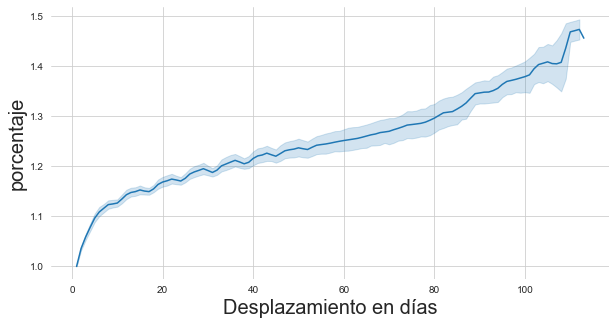

In [34]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x="desplazamiento", y=0,data=ia14_relativa)
#ax.xaxis.set_major_formatter(plt.FuncFormatter(formato_finanzas))
#ax.yaxis.set_major_formatter(plt.FuncFormatter(formato_finanzas))
ax.set_xlabel('Desplazamiento en días',fontsize=20)
ax.set_ylabel('porcentaje',fontsize=20)
ax.grid(True)
lista_texto=[]
sns.despine(bottom=True, left=True)


TypeError: object of type 'NoneType' has no len()

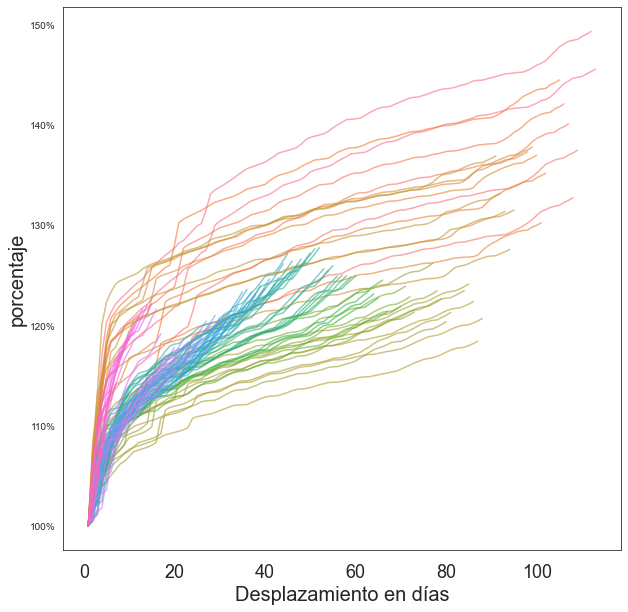

In [36]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10,10))
g=sns.lineplot(x="desplazamiento", ci='sd',hue='fecha',y=0,data=ia14_relativa,ax=ax,alpha=.6)
plt.legend([],[], frameon=False)
#sns.relplot(x="desplazamiento", y=0, kind="line", ci="sd", data=ia14_relativa,ax=ax)
#ax.xaxis.set_major_formatter(plt.FuncFormatter(formato_finanzas))
#ax.yaxis.set_major_formatter(plt.FuncFormatter(formato_finanzas))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:'{:.0f}%'.format(v*100)))
ax.set_xlabel('Desplazamiento en días',fontsize=20)
ax.set_ylabel('porcentaje',fontsize=20)
ax.xaxis.set_tick_params(labelsize=18,width=5,length=10)
lista_x=[i for i in range(0,100,10)]
lista_x=lista_x.append(5)
ax.set_xticks(lista_x)
ax.grid(True)
sns.despine(bottom=True, left=True)